In [1]:
# Importing the libraries to use.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pydicom
import os
import mask_functions

from glob import glob
from collections import defaultdict
from tqdm import tqdm
from mask_functions import rle2mask, mask2rle
from skimage.transform import resize
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint 

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Concatenate
from sklearn.model_selection import train_test_split
import cv2

warnings.filterwarnings("ignore")
%matplotlib inline
%pylab

Using TensorFlow backend.


Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [3]:
# Printing dataset directories.
dataset_path = "./dataset"
rles_path = "train-rle.csv"
print("The dataset folder has two directories:")
print(os.listdir(dataset_path))

# Import the training and test set
train_set = sorted(glob(dataset_path + '/dicom-images-train/*/*/*.dcm'))
test_set = sorted(glob(dataset_path + '/dicom-images-test/*/*/*.dcm'))
rles = pd.read_csv(rles_path)

# Printing the number of images in the training and testing sets
print("\nThe training set has %d images." %(len(train_set)))
print("The Testing set has %d images." %(len(test_set)))

# Importing RLEs

rles = pd.read_csv(rles_path)
rles.columns = ['ImageId', 'EncodedPixels']
print("\nRLES data:")
display(rles.head())

The dataset folder has two directories:
['dicom-images-test', 'dicom-images-train', 'saved_models']

The training set has 10675 images.
The Testing set has 1372 images.

RLES data:


ImageId  \
0  1.2.276.0.7230010.3.1.4.8323329.5597.151787518...   
1  1.2.276.0.7230010.3.1.4.8323329.12515.15178752...   
2  1.2.276.0.7230010.3.1.4.8323329.4904.151787518...   
3  1.2.276.0.7230010.3.1.4.8323329.32579.15178751...   
4  1.2.276.0.7230010.3.1.4.8323329.32579.15178751...   

                                       EncodedPixels  
0                                                 -1  
1                                                 -1  
2   175349 7 1013 12 1009 17 1005 19 1003 20 1002...  
3   407576 2 1021 7 1015 10 1013 12 1011 14 1008 ...  
4   252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1...

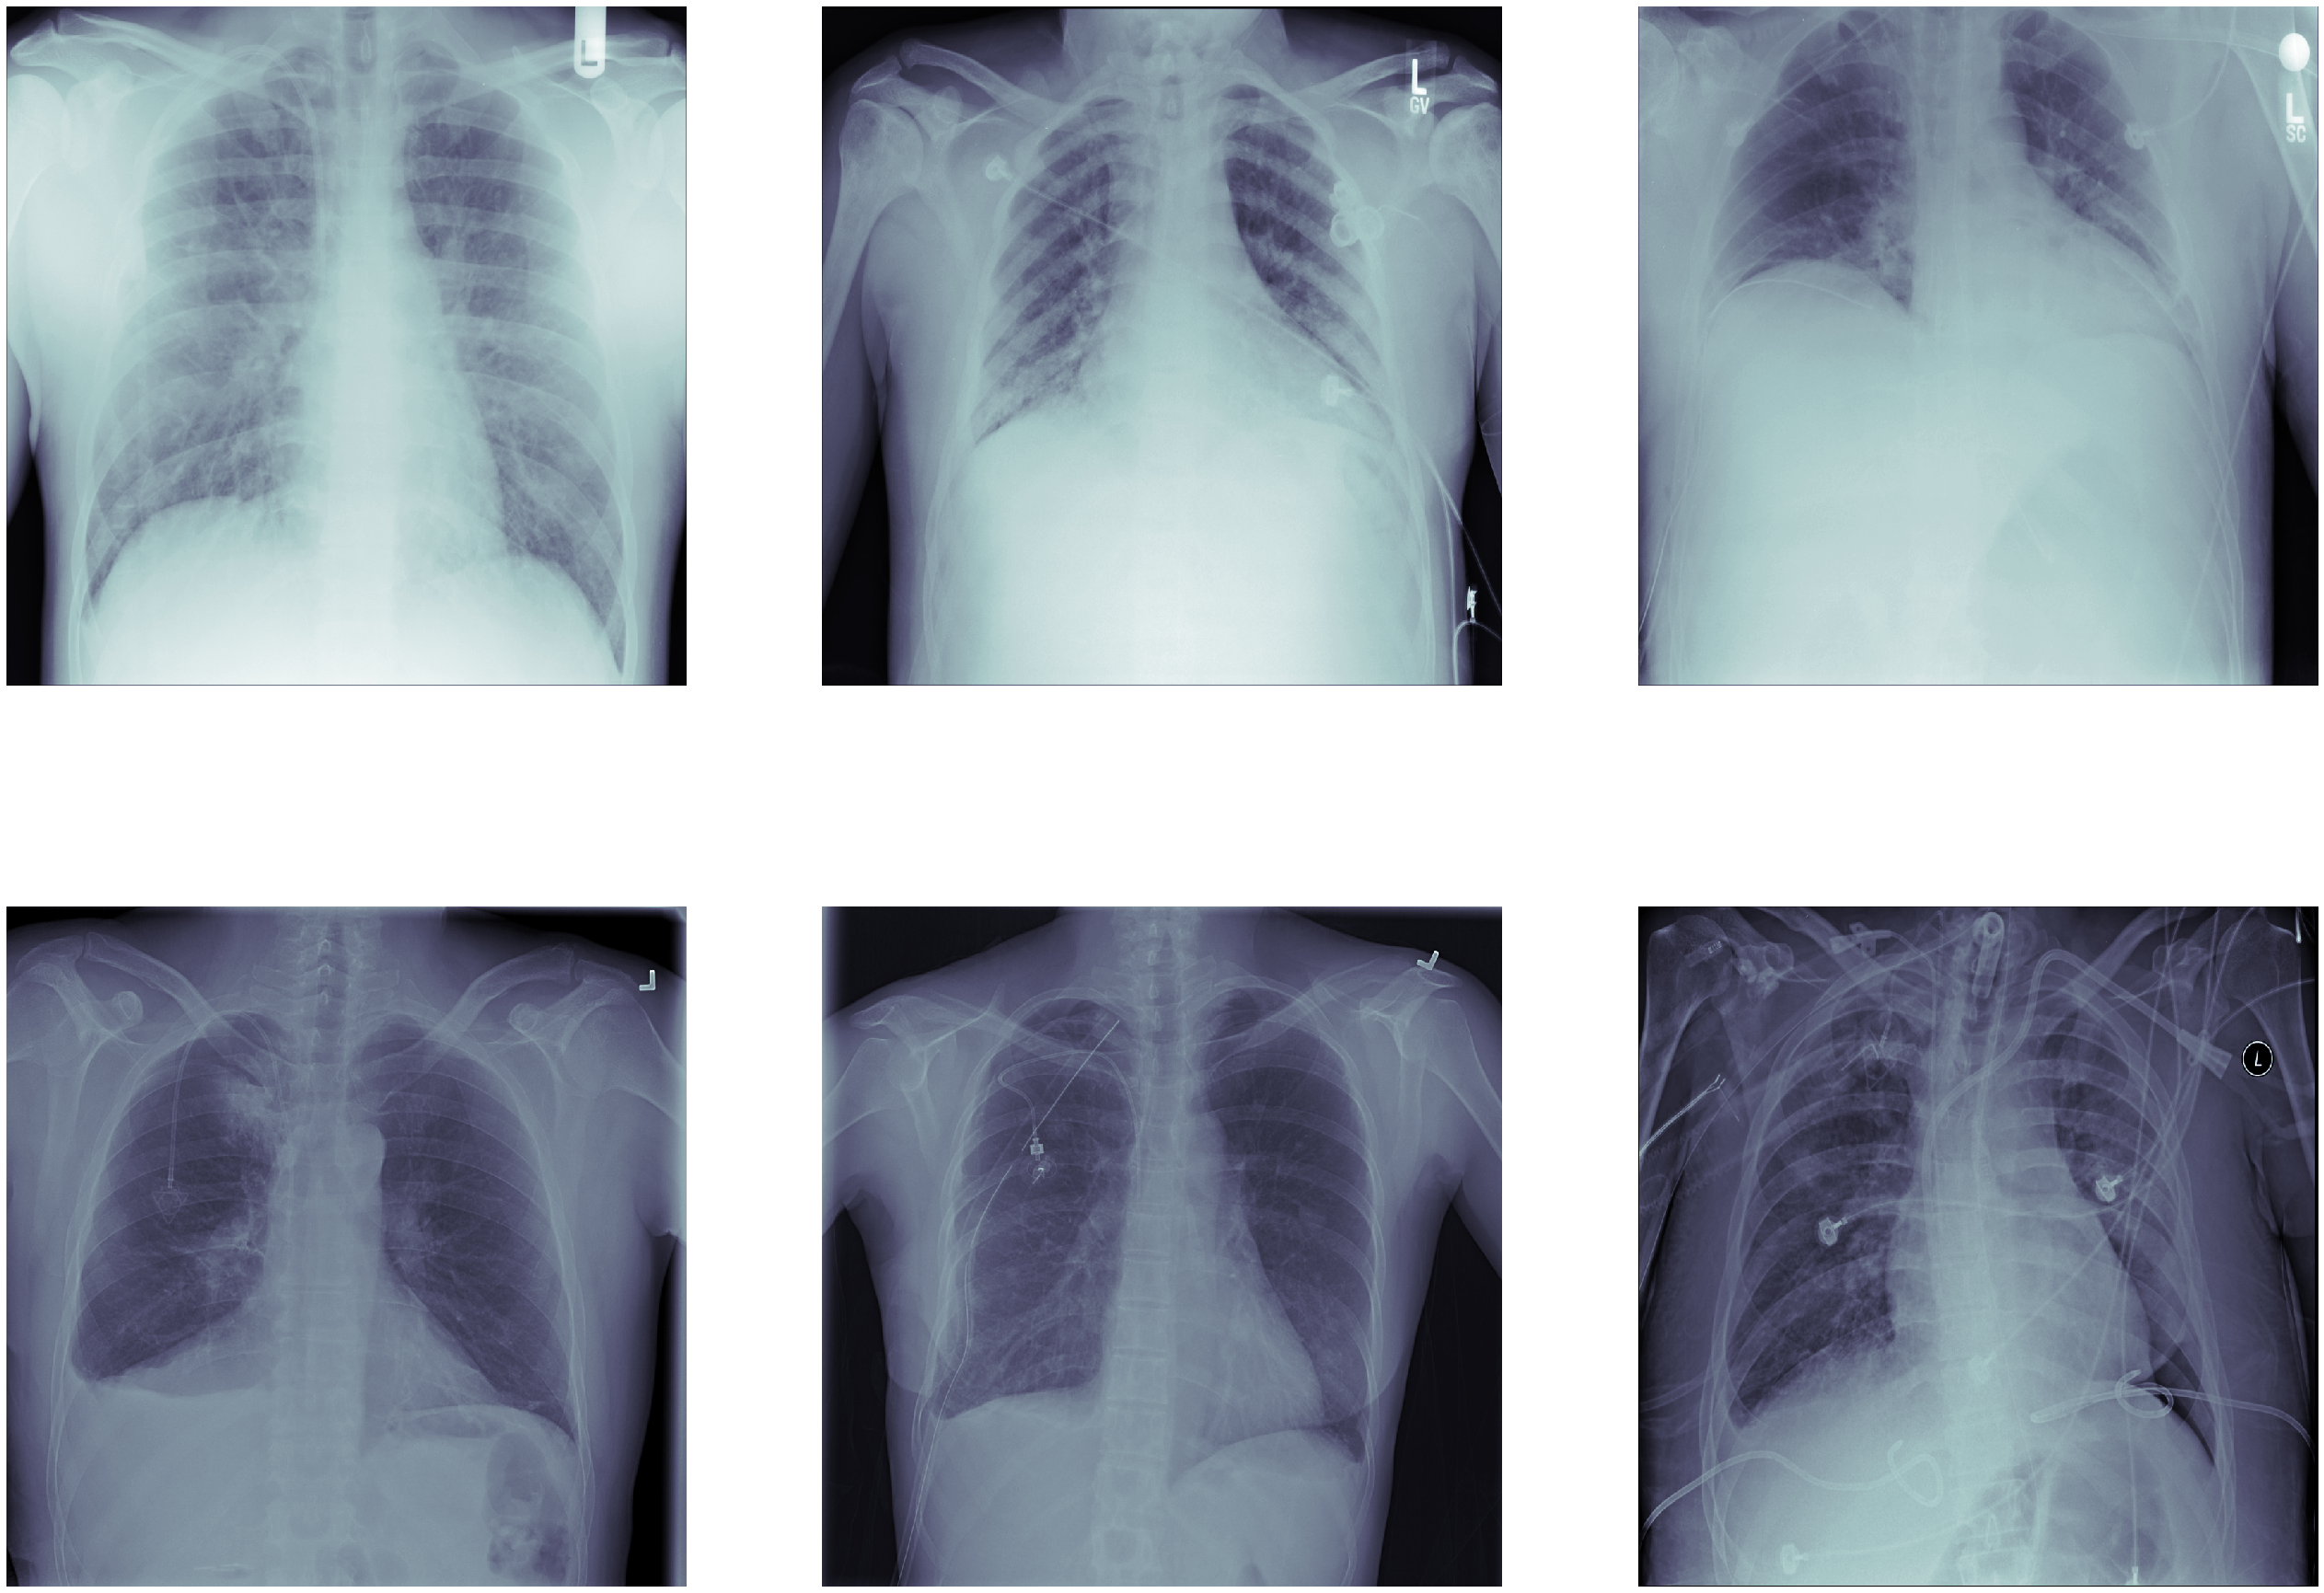

Image shape: (1024, 1024)


In [4]:
# Printing image samples

rows, columns = 2, 3
fig = plt.figure(figsize = (45, 33))

for i in range(1, 7):
    image_file = np.random.choice(train_set)
    img = pydicom.read_file(image_file).pixel_array
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='bone')
    plt.axis('off')
plt.show()
print("Image shape:",img.shape)

In [5]:
# Passing DICOM data and returning relevant fields

def dicom_dataset_to_dict(dicom_data, file_path, rles, encoded_pixels = True):
    dicom_dict = {}  
    
    # Parse fields with meaningful information
    dicom_dict['patient_name'] = dicom_data.PatientName
    dicom_dict['patient_id'] = dicom_data.PatientID
    dicom_dict['patient_age'] = int(dicom_data.PatientAge)
    dicom_dict['patient_sex'] = dicom_data.PatientSex
    dicom_dict['pixel_spacing'] = dicom_data.PixelSpacing
    dicom_dict['file_path'] = file_path
    dicom_dict['id'] = dicom_data.SOPInstanceUID
    
    # Check for annotaion in training set
    if encoded_pixels:
        encoded_pixels_list = rles[rles['ImageId'] == dicom_data.SOPInstanceUID]['EncodedPixels'].values       
        pneumothorax = False
        for encoded_pixels in encoded_pixels_list:
            if encoded_pixels != ' -1':
                pneumothorax = True
        
        # format the data
        dicom_dict['encoded_pixels_list'] = encoded_pixels_list
        dicom_dict['has_pneumothorax'] = pneumothorax
        dicom_dict['encoded_pixels_count'] = len(encoded_pixels_list)
        
    return dicom_dict

In [6]:
# Parse training data

train_data_df1 = pd.DataFrame()
train_data_list = []
for file_path in tqdm(train_set):
    dicom_data = pydicom.dcmread(file_path)
    train_data = dicom_dataset_to_dict(dicom_data, file_path, rles)
    train_data_list.append(train_data)
train_data_df = pd.DataFrame(train_data_list)

100%|██████████| 10675/10675 [00:33<00:00, 321.20it/s]


In [7]:
train_data_df.head()

patient_name                            patient_id  \
0  17d405a3-a0d2-4901-b33a-63906aa48d9f  17d405a3-a0d2-4901-b33a-63906aa48d9f   
1  8ab1ffda-8b65-4914-95d6-2e549e328666  8ab1ffda-8b65-4914-95d6-2e549e328666   
2  bfef51d3-6541-4792-bac1-d21d41ee60fd  bfef51d3-6541-4792-bac1-d21d41ee60fd   
3  d19d956f-4ddd-4688-81ff-909c85e0e2d9  d19d956f-4ddd-4688-81ff-909c85e0e2d9   
4  cf71a760-f693-4ccf-acd4-a41ff4845a5f  cf71a760-f693-4ccf-acd4-a41ff4845a5f   

   patient_age patient_sex   pixel_spacing  \
0           38           M  [0.168, 0.168]   
1           10           F  [0.139, 0.139]   
2           50           F  [0.168, 0.168]   
3           68           F  [0.139, 0.139]   
4           65           M  [0.168, 0.168]   

                                           file_path  \
0  ./dataset/dicom-images-train/1.2.276.0.7230010...   
1  ./dataset/dicom-images-train/1.2.276.0.7230010...   
2  ./dataset/dicom-images-train/1.2.276.0.7230010...   
3  ./dataset/dicom-images-train/1.2.276.0.7230010...   
4  ./dataset/dicom-images-train/1.2.276.0.7230010...   

                                                  id encoded_pixels_list  \
0  1.2.276.0.7230010.3.1.4.8323329.1000.151787516...               [ -1]   
1  1.2.276.0.7230010.3.1.4.8323329.10000.15178752...               [ -1]   
2  1.2.276.0.7230010.3.1.4.8323329.10001.15178752...               [ -1]   
3  1.2.276.0.7230010.3.1.4.8323329.10002.15178752...               [ -1]   
4  1.2.276.0.7230010.3.1.4.8323329.10003.15178752...               [ -1]   

   has_pneumothorax  encoded_pixels_count  
0             False                     1  
1             False                     1  
2             False                     1  
3             False                     1  
4             False                     1

In [8]:
# Parse test data

test_data_df = pd.DataFrame()
test_data_list = []
for file_path in tqdm(test_set):
    dicom_data = pydicom.dcmread(file_path)
    test_data = dicom_dataset_to_dict(dicom_data, file_path, rles)
    test_data_list.append(test_data)
test_data_df = pd.DataFrame(test_data_list)

100%|██████████| 1372/1372 [00:04<00:00, 312.10it/s]


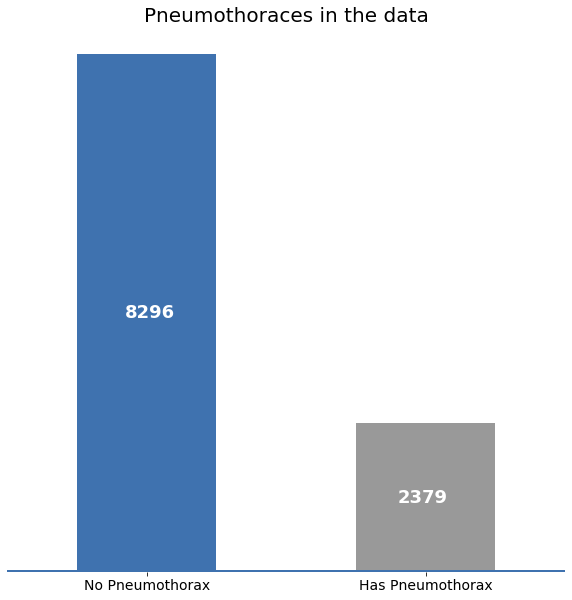

In [9]:
fig = plt.figure(figsize = (10,10 ))
data_ = train_data_df['has_pneumothorax'].value_counts().to_dict()
labels = ['No Pneumothorax', "Has Pneumothorax"]
data_ = pd.Series(dict(zip(labels, list(data_.values()))))

data_.plot.bar(color=('#3f72af', '#999999'))
plt.title("Pneumothoraces in the data", fontsize = 20)
#plt.xlabel("Pneumothorax", fontsize = 14)
#plt.ylabel("Total number", fontsize = 14)
plt.text(-.08, data_[0]/2, data_[0], fontsize = 18, va = 'center', color='white' , fontweight='bold')
plt.text(0.9, data_[1]/2, data_[1], fontsize = 18, va = 'center', color='white' , fontweight='bold')
plt.box(on=None)
plt.xticks(fontsize = 14,rotation='horizontal')
plt.yticks([])
#plt.ylim(0,)
plt.axhline(y = 0, linewidth=5, color='#3f72af')
plt.show()

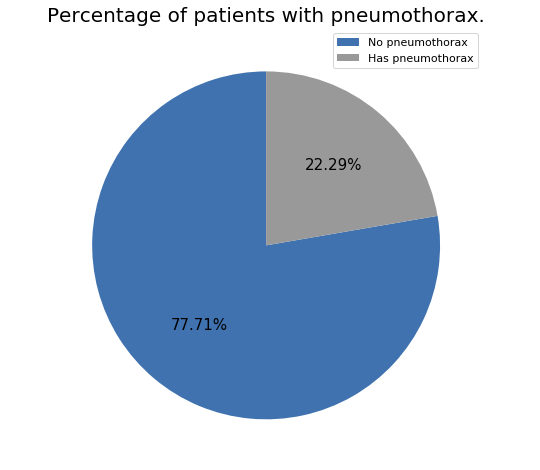

In [10]:
#Data to plot
train_data_to_plot = train_data_df['has_pneumothorax'].value_counts(sort = True)
labels = ('No Pneumothorax', "Has Pneumothorax")
colors = ('#3f72af', '#999999')
rcParams['figure.figsize'] = 8,8

#Plotting the data
patches, texts, autotexts = plt.pie(train_data_to_plot, labels = labels, colors = colors, 
                                    startangle = 90, autopct = '%1.2f%%', shadow = False)
plt.title('Percentage of patients with pneumothorax.', fontsize = 20)
plt.legend(loc = 'upper right', labels = ['No pneumothorax', 'Has pneumothorax'], fontsize = 11)
for _ in texts: 
    _.set_fontsize(15)
    _.set_color('white')
for __ in autotexts: 
    __.set_fontsize(15)
plt.show()

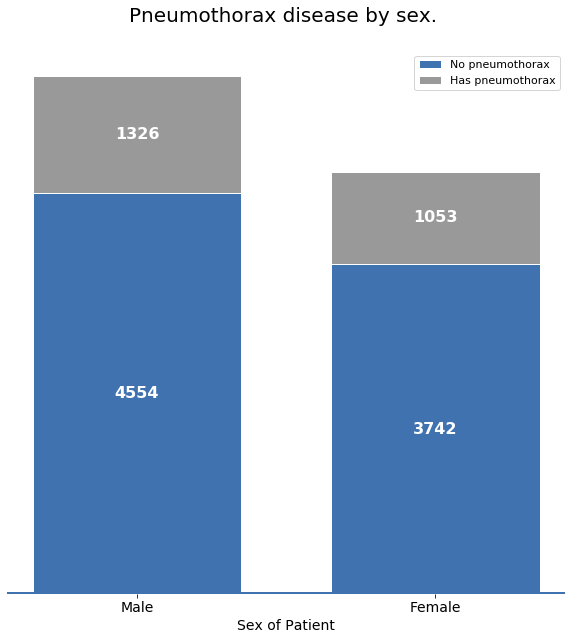

In [11]:
male_train = train_data_df[train_data_df['patient_sex'] == 'M']
female_train = train_data_df[train_data_df['patient_sex'] == 'F']

male_negative = len(male_train[male_train['has_pneumothorax'] == 0])
female_negative = len(female_train[female_train['has_pneumothorax'] == 0])
male_positive = len(male_train[male_train['has_pneumothorax'] == 1])
female_positive = len(female_train[female_train['has_pneumothorax'] == 1])

r = [0, 1]
barWidth = 0.7
x_labels = ["Male", "Female"]

bar1 = [male_negative, female_negative]
bar2 = [male_positive, female_positive]
bar_height = np.add(bar1, bar2).tolist()

fig = plt.figure(figsize = (10, 10))
b1 = plt.bar(r, bar1, color = '#3f72af', edgecolor = 'white', width = barWidth)
b2 = plt.bar(r, bar2, bottom = bar1, color = '#999999', edgecolor = 'white', width = barWidth)
plt.xticks(r, x_labels, fontsize = 14)
plt.yticks([])
plt.xlabel("Sex of Patient", fontsize = 14)
plt.legend(loc = 'upper right', labels = ['No pneumothorax', 'Has pneumothorax'], fontsize = 11)
plt.title('Pneumothorax disease by sex. \n', fontsize = 20)
plt.box(on = None)
plt.ylim(0,)
plt.axhline(y = 0, linewidth = 5, color = '#3f72af')

for a, b in zip(b1, b2):
    h1 = a.get_height()
    h2 = b.get_height()
    plt.text(a.get_x() + a.get_width() / 2, h1 / 2, h1, horizontalalignment="center", 
             verticalalignment = "center", color = "white", fontsize = 16, fontweight = "bold")
    plt.text(b.get_x() + b.get_width() / 2, h1 + h2 / 2, h2, verticalalignment = "center", 
             horizontalalignment = "center", color = "white", fontsize = 16, fontweight = "bold")

plt.show()

In [12]:
males_in_dataset = male_negative + male_positive
females_in_dataset = female_negative + female_positive
male_ratio = males_in_dataset/(males_in_dataset + females_in_dataset)
female_ratio = females_in_dataset/(males_in_dataset + females_in_dataset)
print('Ratio of males to females in the data set is %.2f to %.2f'% (male_ratio, female_ratio))

Ratio of males to females in the data set is 0.55 to 0.45


In [13]:
# Histogram of patients having pneumothorax and those that don't

# Splitting the data 
has_pneumothorax_train = train_data_df[train_data_df['has_pneumothorax'] == True]
no_pneumothorax_train = train_data_df[train_data_df['has_pneumothorax'] == False]

In [14]:
has_pneumothorax_train.head(3)

patient_name  \
6   bf8b1e5d-7ae8-4f5b-a387-8e0bb40733f1   
13  d3349d82-de72-443b-bd0e-00ac6177621f   
14  13ca140b-4e88-4f62-916d-e7a2bd2bde44   

                              patient_id  patient_age patient_sex  \
6   bf8b1e5d-7ae8-4f5b-a387-8e0bb40733f1           53           F   
13  d3349d82-de72-443b-bd0e-00ac6177621f           77           M   
14  13ca140b-4e88-4f62-916d-e7a2bd2bde44           74           F   

                                 pixel_spacing  \
6   [0.14300000000000002, 0.14300000000000002]   
13  [0.19431099999999998, 0.19431099999999998]   
14                              [0.168, 0.168]   

                                            file_path  \
6   ./dataset/dicom-images-train/1.2.276.0.7230010...   
13  ./dataset/dicom-images-train/1.2.276.0.7230010...   
14  ./dataset/dicom-images-train/1.2.276.0.7230010...   

                                                   id  \
6   1.2.276.0.7230010.3.1.4.8323329.10005.15178752...   
13  1.2.276.0.7230010.3.1.4.8323329.10011.15178752...   
14  1.2.276.0.7230010.3.1.4.8323329.10012.15178752...   

                                  encoded_pixels_list  has_pneumothorax  \
6   [ 209126 1 1019 6 1015 10 1012 13 1010 14 1008...              True   
13  [ 891504 5 1018 8 1015 10 1013 12 1011 14 1009...              True   
14  [ 261328 6 1015 11 1011 15 1007 18 1004 21 100...              True   

    encoded_pixels_count  
6                      1  
13                     3  
14                     3

In [15]:
no_pneumothorax_train['file_path'][0]

'./dataset/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.1000.1517875165.878026/1.2.276.0.7230010.3.1.3.8323329.1000.1517875165.878025/1.2.276.0.7230010.3.1.4.8323329.1000.1517875165.878027.dcm'

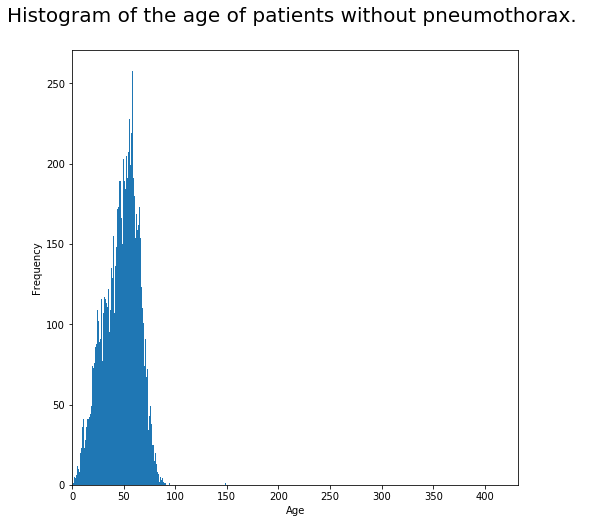

In [16]:
no_pneumothorax_train['patient_age'].plot.hist(bins = range(1,max(no_pneumothorax_train['patient_age']),1))
plt.xlim(0,)
plt.xlabel('Age')
plt.title('Histogram of the age of patients without pneumothorax. \n', fontsize = 20)
plt.show()

In [17]:
no_pneumo_age = no_pneumothorax_train['patient_age'].unique()
print('Unique ages:\n\n',no_pneumo_age)
print('\nMax age:',max(no_pneumo_age))

Unique ages:

 [ 38  10  50  68  65  45  55  26  63  37  14  54   9  66  40  70   5  64
  46  58  56  16  35  47  43  49  36  44  30  22  34  52  33  41  61  25
  42  31  72  57  51  39  60  71  15  12  75  77  28  53  13  19  24  48
  32  74  29  67  94  20  81  23  59  69  18  21  62  11  87   7  73  80
  78  79  27  76   8   4  83  17 413  85   6  82   2  86   3  84  90  89
  88   1 148]

Max age: 413


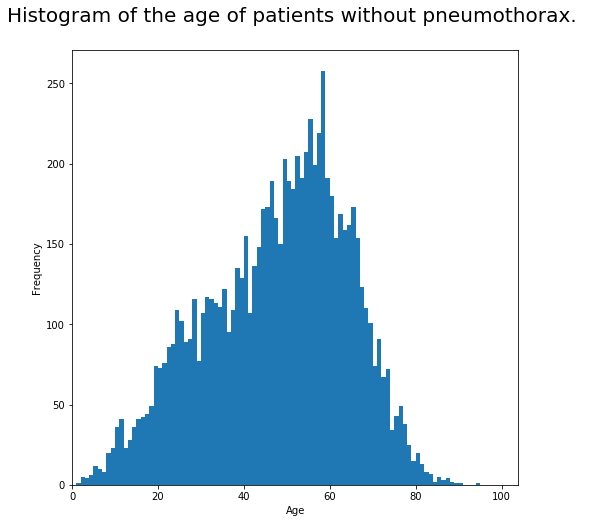

In [18]:
no_pneumothorax_train['patient_age'].plot.hist(bins = range(1,100,1))
plt.xlim(0,)
plt.xlabel('Age')
plt.title('Histogram of the age of patients without pneumothorax. \n', fontsize = 20)
plt.show()

In [19]:
has_pneumothorax_train['patient_age'].plot.hist(bins = 
                                    range(1,max(has_pneumothorax_train['patient_age']),1), color = '#999999')
plt.xlim(0,)
plt.xlabel('Age')
plt.title('Histogram of the age of patients with pneumothorax. \n', fontsize = 20)
plt.show()

In [20]:
# From https://www.kaggle.com/robertkag/rle-to-mask-converter

def rleToMask(rleString,pixel_spacing):
    height = pixel_spacing[0]
    width = pixel_spacing[1]
    rows,cols = height,width
    rleNumbers = [int(numstring) for numstring in rleString.split(' ')]
    rlePairs = np.array(rleNumbers).reshape(-1,2)
    img = np.zeros(rows*cols,dtype=np.uint8)
    for index,length in rlePairs:
        index -= 1
        img[index:index+length] = 255
        img = img.reshape(cols,rows)
    return img 

In [21]:
# Getting the affected area percentage

def infected_area (encoded_mask, pixel_spacing):
    total_pixels = 0
    
    for pixels,  in encoded_mask:
        decoded_mask = rleToMask(pixels, pixel_spacing).T
        total_pixels += np.count_nonzero(decoded_mask)
    area_per_pixel = pixel_spacing[0] * pixel_spacing[1]
    return area_per_pixel * total_pixels    

In [22]:
# Create a pneumothorax patients dataset subset
pneumothorax_df = train_data_df[train_data_df['has_pneumothorax']== 1].copy()
# get sum of non zero elements in mask
'''pneumothorax_df['pneumothorax_area'] = pneumothorax_df.apply(
    lambda row: infected_area(row['encoded_pixels_list'], row['pixel_spacing']),axis=1)'''

"pneumothorax_df['pneumothorax_area'] = pneumothorax_df.apply(\n    lambda row: infected_area(row['encoded_pixels_list'], row['pixel_spacing']),axis=1)"

In [23]:
pneumothorax_df.head(3)

patient_name  \
6   bf8b1e5d-7ae8-4f5b-a387-8e0bb40733f1   
13  d3349d82-de72-443b-bd0e-00ac6177621f   
14  13ca140b-4e88-4f62-916d-e7a2bd2bde44   

                              patient_id  patient_age patient_sex  \
6   bf8b1e5d-7ae8-4f5b-a387-8e0bb40733f1           53           F   
13  d3349d82-de72-443b-bd0e-00ac6177621f           77           M   
14  13ca140b-4e88-4f62-916d-e7a2bd2bde44           74           F   

                                 pixel_spacing  \
6   [0.14300000000000002, 0.14300000000000002]   
13  [0.19431099999999998, 0.19431099999999998]   
14                              [0.168, 0.168]   

                                            file_path  \
6   ./dataset/dicom-images-train/1.2.276.0.7230010...   
13  ./dataset/dicom-images-train/1.2.276.0.7230010...   
14  ./dataset/dicom-images-train/1.2.276.0.7230010...   

                                                   id  \
6   1.2.276.0.7230010.3.1.4.8323329.10005.15178752...   
13  1.2.276.0.7230010.3.1.4.8323329.10011.15178752...   
14  1.2.276.0.7230010.3.1.4.8323329.10012.15178752...   

                                  encoded_pixels_list  has_pneumothorax  \
6   [ 209126 1 1019 6 1015 10 1012 13 1010 14 1008...              True   
13  [ 891504 5 1018 8 1015 10 1013 12 1011 14 1009...              True   
14  [ 261328 6 1015 11 1011 15 1007 18 1004 21 100...              True   

    encoded_pixels_count  
6                      1  
13                     3  
14                     3

In [24]:
def get_affected_area(encoded_pixels_list, pixel_spacing):
    
    # take the encoded mask, decode, and get the sum of nonzero elements
    pixel_sum = 0
    
    for encoded_mask in encoded_pixels_list:
        mask_decoded = rle2mask(encoded_mask, 1024, 1024).T
        pixel_sum += np.count_nonzero(mask_decoded)
        
    area_per_pixel = pixel_spacing[0] * pixel_spacing[1]
    
    return pixel_sum * area_per_pixel

In [25]:
# create a subset of dataframe for pneumothorax patients
pneumothorax_df = train_data_df[train_data_df['has_pneumothorax']==1].copy()
# get sum of non zero elements in mask
pneumothorax_df['pneumothorax_area'] = pneumothorax_df.apply(lambda row: 
                                    get_affected_area(row['encoded_pixels_list'], row['pixel_spacing']),axis=1)

In [26]:
pneumothorax_df_m = pneumothorax_df[pneumothorax_df['patient_sex']=='M']
pneumothorax_df_f = pneumothorax_df[pneumothorax_df['patient_sex']=='F']
pneumo_size_m = pneumothorax_df_m['pneumothorax_area'].values
pneumo_size_f = pneumothorax_df_f['pneumothorax_area'].values

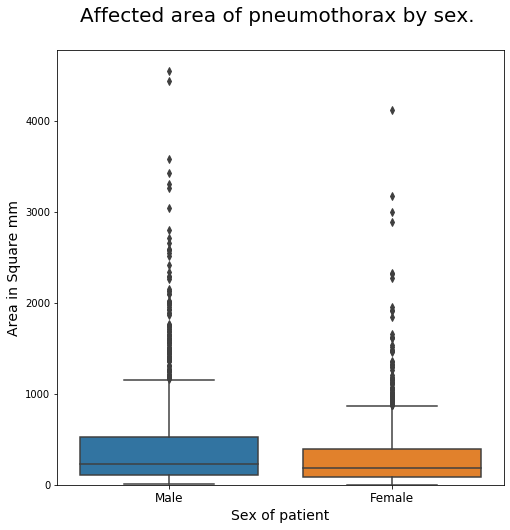

In [27]:
data = [pneumo_size_m, pneumo_size_f]
tick =[0,1]
x_labels = ['Male', "Female"]
fig = plt.figure(figsize = (8, 8))
ax = sns.boxplot(data =data)
plt.xlabel("Sex of patient", fontsize = 14)
plt.ylabel('Area in Square mm', fontsize = 14)
plt.title("Affected area of pneumothorax by sex. \n", fontsize = 20)
plt.xticks(tick, x_labels, fontsize = 12)
plt.ylim(0,)
plt.show()

In [28]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input, Conv2D, MaxPool2D, UpSampling2D, Concatenate, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
import cv2
import tensorflow
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator

In [29]:
# Creating a benchmark convolutional model
image_size = 256
model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 2, padding = 'same', activation = 'relu', 
                 input_shape = (image_size, image_size, 1)))
model.add(Dropout(0.3))
model.add(MaxPool2D(pool_size = 2))
model.add(Conv2D(filters = 32, kernel_size = 2, padding = 'same', activation = 'relu'))
model.add(Dropout(0.5))
model.add(MaxPool2D(pool_size = 2))
model.add(Conv2D(filters = 64, kernel_size = 2, padding = 'same', activation = 'relu'))
model.add(Dropout(0.4))
model.add(MaxPool2D(pool_size = 2))
model.add(Flatten())
model.add(Dense(500, activation = 'relu'))
model.add(Dense(1, activation = 'relu'))

model.summary()

W0909 20:23:56.714075 140237279024896 deprecation_wrapper.py:119] From /home/ronald/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0909 20:23:56.716266 140237279024896 deprecation_wrapper.py:119] From /home/ronald/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0909 20:23:56.722024 140237279024896 deprecation_wrapper.py:119] From /home/ronald/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0909 20:23:56.740185 140237279024896 deprecation_wrapper.py:119] From /home/ronald/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 16)      80        
_________________________________________________________________
dropout_1 (Dropout)          (None, 256, 256, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        8256      
__________

In [30]:
pneumothorax_df['has_pneumo_encoded'] = pneumothorax_df['has_pneumothorax'].apply(lambda x: 1 if x==True else 0)
pneumothorax_df.head(3)

patient_name  \
6   bf8b1e5d-7ae8-4f5b-a387-8e0bb40733f1   
13  d3349d82-de72-443b-bd0e-00ac6177621f   
14  13ca140b-4e88-4f62-916d-e7a2bd2bde44   

                              patient_id  patient_age patient_sex  \
6   bf8b1e5d-7ae8-4f5b-a387-8e0bb40733f1           53           F   
13  d3349d82-de72-443b-bd0e-00ac6177621f           77           M   
14  13ca140b-4e88-4f62-916d-e7a2bd2bde44           74           F   

                                 pixel_spacing  \
6   [0.14300000000000002, 0.14300000000000002]   
13  [0.19431099999999998, 0.19431099999999998]   
14                              [0.168, 0.168]   

                                            file_path  \
6   ./dataset/dicom-images-train/1.2.276.0.7230010...   
13  ./dataset/dicom-images-train/1.2.276.0.7230010...   
14  ./dataset/dicom-images-train/1.2.276.0.7230010...   

                                                   id  \
6   1.2.276.0.7230010.3.1.4.8323329.10005.15178752...   
13  1.2.276.0.7230010.3.1.4.8323329.10011.15178752...   
14  1.2.276.0.7230010.3.1.4.8323329.10012.15178752...   

                                  encoded_pixels_list  has_pneumothorax  \
6   [ 209126 1 1019 6 1015 10 1012 13 1010 14 1008...              True   
13  [ 891504 5 1018 8 1015 10 1013 12 1011 14 1009...              True   
14  [ 261328 6 1015 11 1011 15 1007 18 1004 21 100...              True   

    encoded_pixels_count  pneumothorax_area  has_pneumo_encoded  
6                      1         136.640218                   1  
13                     3         297.334522                   1  
14                     3         911.522304                   1

In [31]:
def resize_dicom_image(image_path):
    #new_size = 256
    img = pydicom.read_file(image_path).pixel_array
    resized_img = resize(img, (image_size, image_size))
    x = image.img_to_array(resized_img)
    return np.expand_dims(x, axis=0)

In [32]:
def resize_dicom_images(img_paths):
    list_of_tensors = [resize_dicom_image(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [33]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

W0909 20:23:57.069276 140237279024896 deprecation_wrapper.py:119] From /home/ronald/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0909 20:23:57.089619 140237279024896 deprecation_wrapper.py:119] From /home/ronald/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0909 20:23:57.093948 140237279024896 deprecation.py:323] From /home/ronald/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [34]:
train_files = pneumothorax_df['file_path']
target_files = pneumothorax_df['has_pneumo_encoded']

np.sort(train_files)
np.sort(target_files)
#np.random.seed(42)
#np.random.shuffle(train_files)

split = int(0.8 * len(train_files))
train_filenames = train_files[:split]
valid_filenames = train_files[split:]

split = int(0.8 * len(target_files))
train_targets = target_files[:split]
valid_targets = target_files[split:]

In [35]:
train_files.head()

6     ./dataset/dicom-images-train/1.2.276.0.7230010...
13    ./dataset/dicom-images-train/1.2.276.0.7230010...
14    ./dataset/dicom-images-train/1.2.276.0.7230010...
18    ./dataset/dicom-images-train/1.2.276.0.7230010...
28    ./dataset/dicom-images-train/1.2.276.0.7230010...
Name: file_path, dtype: object

In [36]:
train_tensors = resize_dicom_images(train_filenames).astype('float32')/255
valid_tensors = resize_dicom_images(valid_filenames).astype('float32')/255

100%|██████████| 476/476 [00:04<00:00, 117.99it/s]


In [ ]:
epochs = 2
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)
model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=80, callbacks=[checkpointer], verbose=1)

Train on 1903 samples, validate on 476 samples
Epoch 1/200
 480/1903 [======>.......................] - ETA: 1:17 - loss: 0.3785 - acc: 0.0104

In [ ]:
# model.save('saved_models/weights.best.from_scratch.hdf5')

In [ ]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')